In [7]:
#Склеить изображение (5 х 5)
#Убрать градиенты по краям
#Убрать линии склейки
#Выделить контуры животных
#Найти контур одного и того же животного на всех изображениях
#Отследить изменение площади
#Можно показать, какие части контурв растягиваются / сжимаются
#Отследить перемещение
!pip install opencv-python

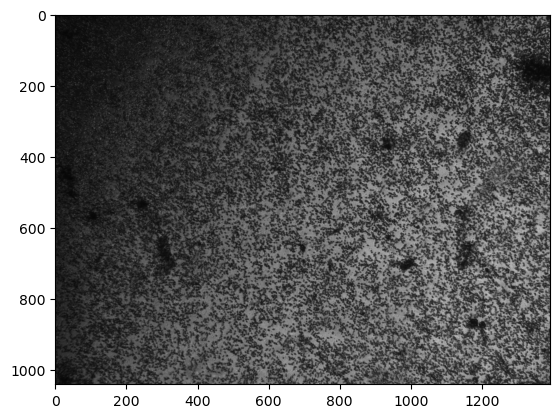

In [8]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

img = cv.imread("./data/Well B1_01/2020_02_21_19_01_45_57.tif")
plt.imshow(img)

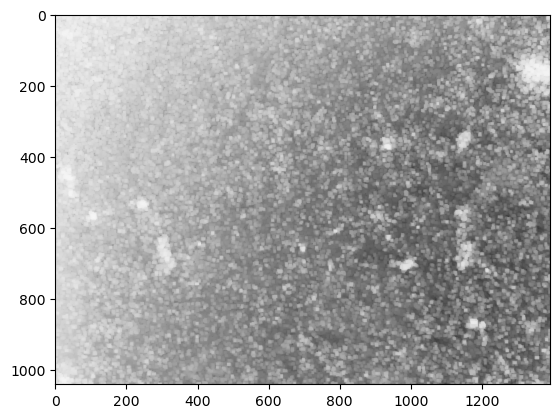

In [9]:
def morph_open(img, morph_size):
    element = cv.getStructuringElement(cv.MORPH_RECT, (2 * morph_size + 1, 2 * morph_size + 1), (morph_size, morph_size))
    return cv.morphologyEx(img, cv.MORPH_OPEN, element)
opened = morph_open(255 - img, 3)
plt.imshow(opened)

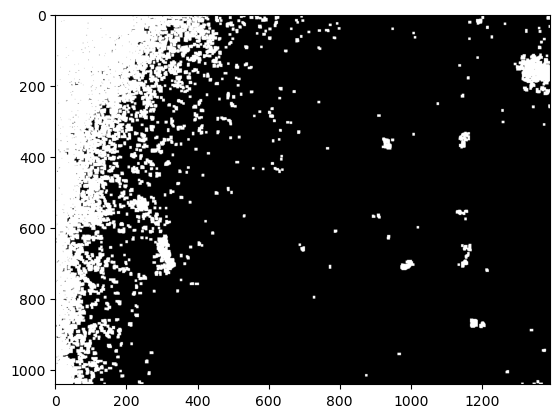

In [10]:
_, thresholded = cv.threshold(opened, 200, 255, cv.THRESH_BINARY)
plt.imshow(thresholded)

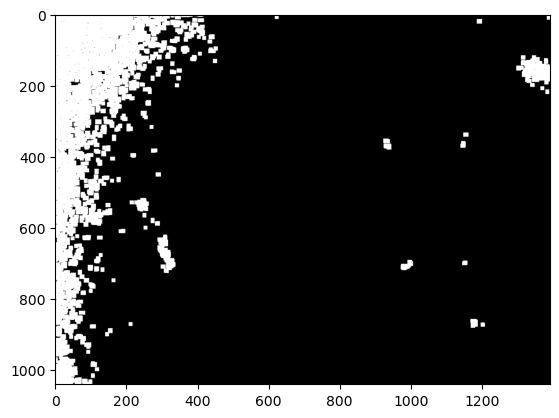

In [11]:
opened2 = morph_open(thresholded, 5)
plt.imshow(opened2)

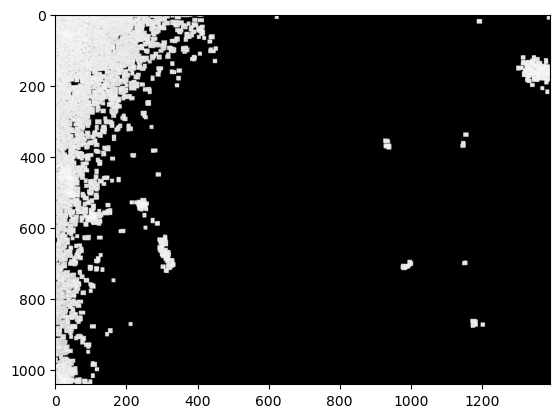

In [12]:
plants = img - img * opened2
plt.imshow(img - plants)

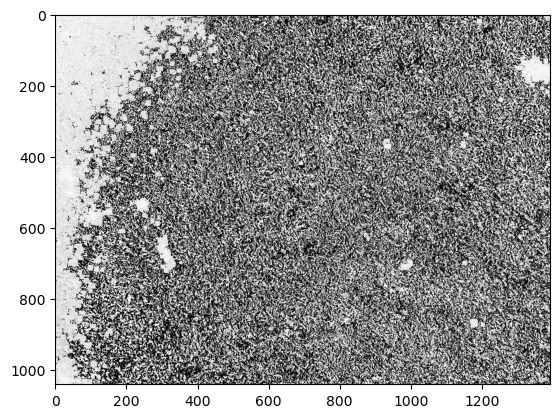

In [13]:
img1 = cv.imread("./data/Well B1_01/2020_02_21_19_03_42_77.tif")
minus_plants = img1 - plants
plt.imshow(minus_plants)

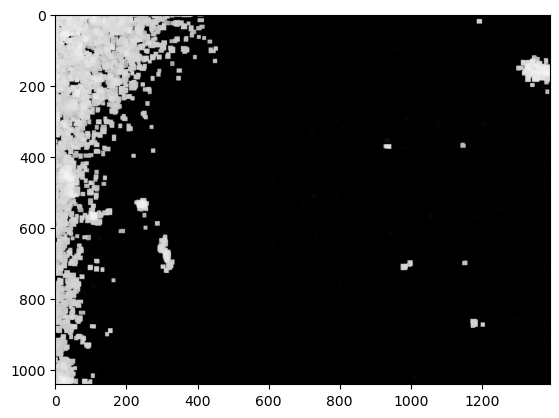

In [14]:
opened3 = morph_open(minus_plants, 5)
plt.imshow(opened3)

In [15]:
from os import listdir
deleted_directories = [20, 21, 23, 24, 25]
for i in range(25):
    index = i + 1
    if index in deleted_directories:
        continue
    if index < 10:
        index = f"0{index}"
    directory = f"Well B1_{index}"
    print(len(listdir(f"./data/{directory}")))

84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84


In [16]:
def combine_files():
    rows = []
    for y in range(5):
        rows.append([])
        for x in range(5):
            index = y * 5 + x + 1
            if index in deleted_directories:
                rows[y].append(None)
                continue
            if index < 10:
                index = f"0{index}"
            directory = f"Well B1_{index}"
            rows[y].append(listdir(f"./data/{directory}"))
    count = len(rows[0][0])
    images = [[] for _ in range(count)]
    for y in range(5):
        for x in range(5):
            col = rows[y][x]
            if col is None:
                for i in range(count):
                  images[i].append(None)
                continue
            for i in range(count):
              images[i].append(col[i])
    return images

In [17]:
image_names = combine_files()
print(image_names[0])

['2020_02_21_19_01_45_57.tif', '2020_02_21_19_01_47_43.tif', '2020_02_21_19_01_49_86.tif', '2020_02_21_19_01_52_17.tif', '2020_02_21_19_01_54_02.tif', '2020_02_21_19_02_04_12.tif', '2020_02_21_19_02_01_98.tif', '2020_02_21_19_01_59_95.tif', '2020_02_21_19_01_57_85.tif', '2020_02_21_19_01_55_62.tif', '2020_02_21_19_02_06_04.tif', '2020_02_21_19_02_07_91.tif', '2020_02_21_19_02_10_34.tif', '2020_02_21_19_02_12_73.tif', '2020_02_21_19_02_14_48.tif', '2020_02_21_19_02_24_44.tif', '2020_02_21_19_02_22_48.tif', '2020_02_21_19_02_20_51.tif', '2020_02_21_19_02_18_14.tif', None, None, '2020_02_21_19_02_28_50.tif', None, None, None]


In [18]:
count = len(image_names)
images = [[] for _ in range(count)]
for i in range(count):
    for j in range(25):
        index = j + 1
        if index < 10:
            index = f"0{index}"
        if not image_names[i][j]:
            images[i].append(None)
            continue
        images[i].append(cv.imread(f"./data/Well B1_{index}/{image_names[i][j]}"))

In [19]:
max_y = images[0][0].shape[0]
max_x = images[0][0].shape[1]
print(f"{max_y} {max_x}")

1040 1392


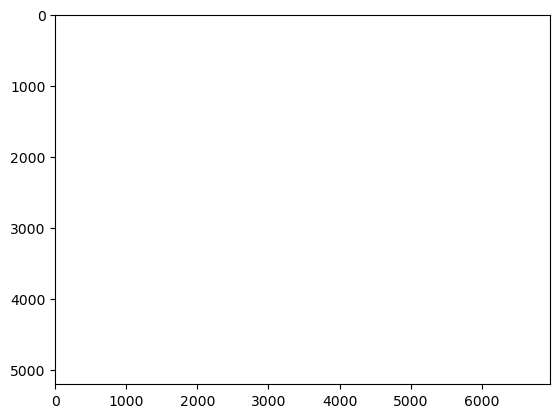

In [20]:
def create_white(color = 255):
    return np.zeros((max_y * 5, max_x * 5, 3), np.uint8) + color
plt.imshow(create_white())

In [21]:
final_images = []
for i in range(count):
    white = create_white()
    final_images.append(white)
    for y in range(5):
        for x in range(5):
            index = y * 5 + x
            if images[0][index] is None:
                continue
            white[y * max_y:(y + 1) * max_y, x * max_x:(x + 1) * max_x] = images[i][index][:]

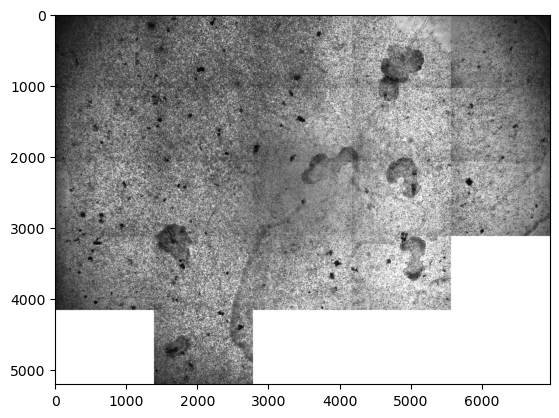

In [22]:
plt.imshow(final_images[0])

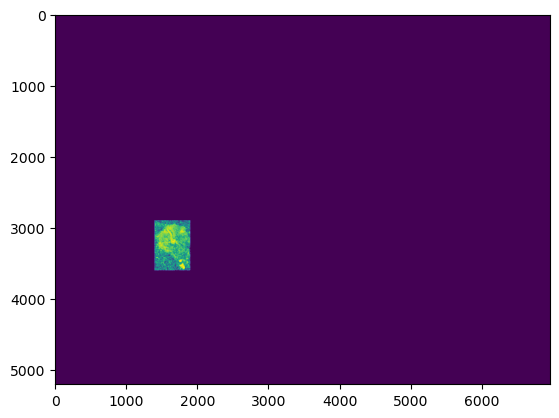

In [78]:
image = final_images[0]
def preprocessing(image):
    gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    thickness = 10
    line_type = 8
    white = create_white()
    cv.ellipse(white,
                (5 * max_x // 2, 5 * max_y // 2),
                (max_y * 5, max_x * 5 // 2),
                90,
                0,
                360,
                (0, 0, 0),
                -thickness,
                line_type)
    white = 255 - white
    white = cv.cvtColor(white, cv.COLOR_BGR2GRAY)
    white = white / 255.0
    cut = (255 - gray) * white
    return cut
cut = preprocessing(image)
x = 1400
y = 2900
w = 500
h = 700
white = create_white(0)
cv.rectangle(white, (x, y), (x + w, y + h), (1, 1, 1), -1)
white = cv.cvtColor(white, cv.COLOR_BGR2GRAY)
object_mask = white * cut
plt.imshow(object_mask)

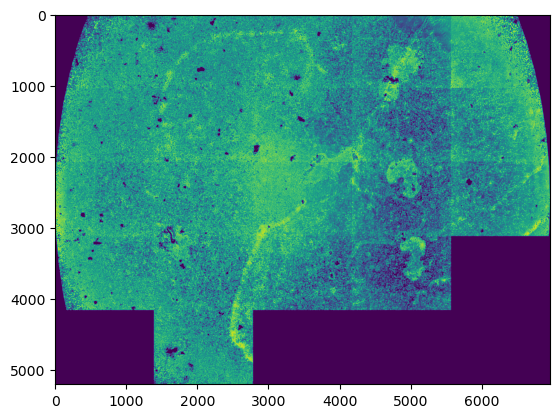

In [24]:
def delete_outliers(image, threshold):
    out = np.zeros(image.shape, np.uint8)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y, x] <= threshold:
                out[y, x] = image[y, x]
    return out
deleted = delete_outliers(cut, 200)
plt.imshow(deleted)

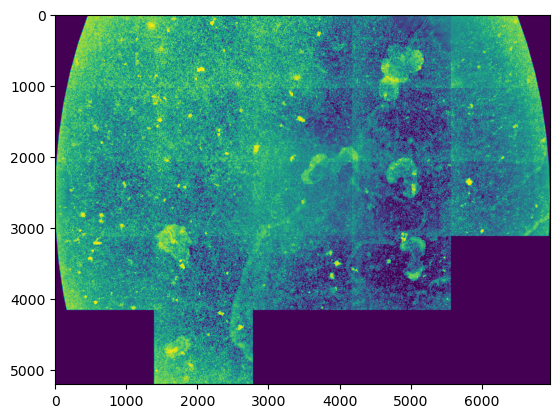

In [25]:
def delete_useless(image, threshold):
    out = np.zeros(image.shape, np.uint8)
    for y in range(1, image.shape[0] - 1):
        for x in range(1, image.shape[1] - 1):
            hasAllNeighbors = True
            hasAllNeighbors = hasAllNeighbors and image[y + 1, x + 1] > threshold
            hasAllNeighbors = hasAllNeighbors and image[y + 1, x - 1] > threshold            
            hasAllNeighbors = hasAllNeighbors and image[y - 1, x - 1] > threshold            
            hasAllNeighbors = hasAllNeighbors and image[y - 1, x + 1] > threshold   
            if hasAllNeighbors:
                out[y, x] = image[y, x]
    return out
deleted = delete_useless(cut, 25)
plt.imshow(deleted)

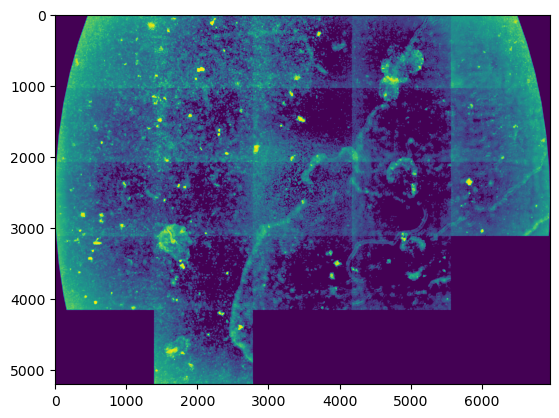

In [26]:
opened = morph_open(deleted, 5)
plt.imshow(opened)

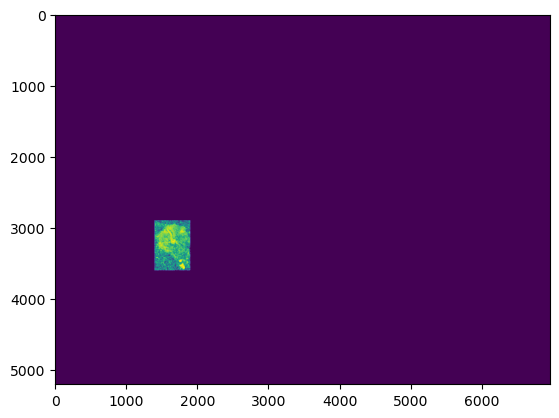

In [28]:
plt.imshow(object_mask)

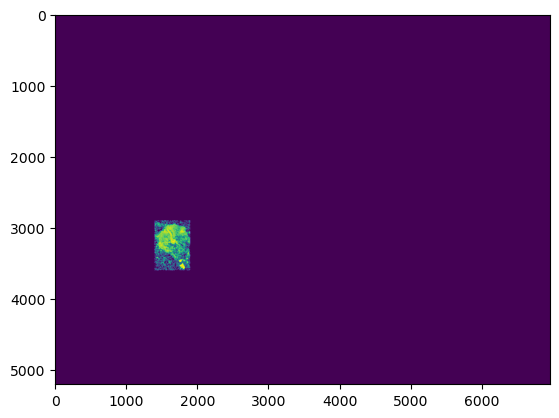

In [29]:
deleted = delete_useless(object_mask, 100)
plt.imshow(deleted)

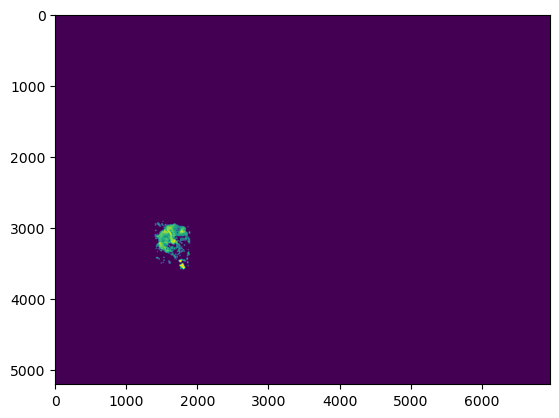

In [30]:
opened = morph_open(deleted, 5)
plt.imshow(opened)

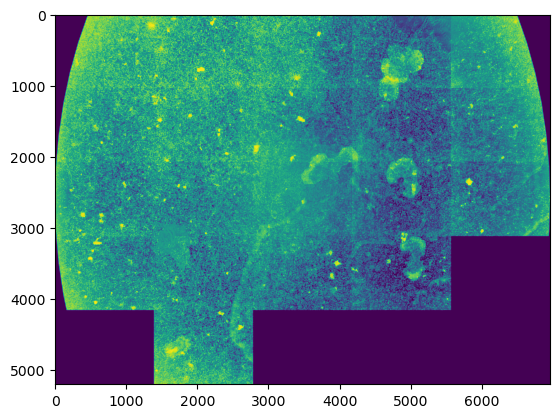

In [168]:
plants = cut - 0.4 * opened
plt.imshow(plants)

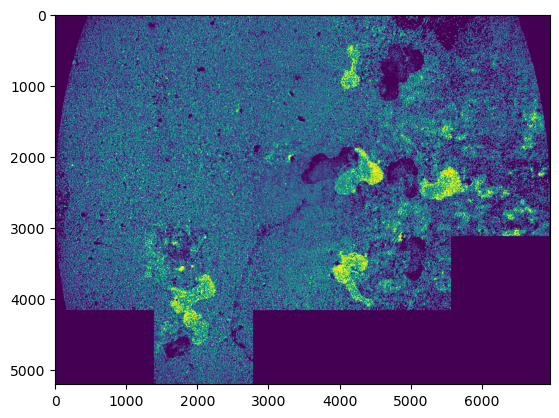

In [177]:
_, objects = cv.threshold(preprocessing(final_images[83]) - plants, 25, 255, cv.THRESH_BINARY)
plt.imshow(objects)

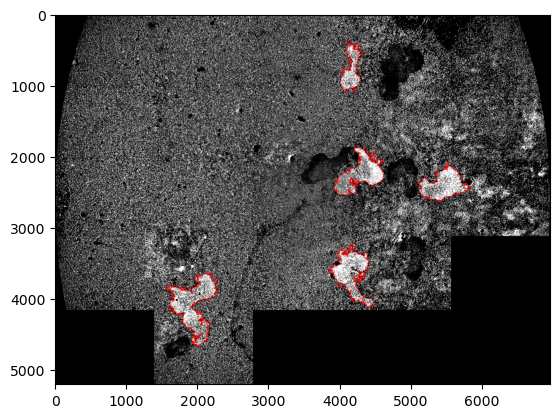

In [173]:
converted = objects.astype('uint8')
contours, hierarchy = cv.findContours(converted, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
colored = cv.cvtColor(converted, cv.COLOR_BGR2RGB)
max_lengths = [(0, None)] * 5 #(length, contour)
for contour in contours:
    contour_size = 1
    for length in contour.shape:
        contour_size = contour_size * length
    max_lengths.append((contour_size, contour))
    max_lengths = list(sorted(max_lengths, key=lambda c: c[0]))[-5:]
new_contours = list(reversed(list(map(lambda c: c[1], max_lengths))))
cv.drawContours(colored, new_contours, -1, (255, 0, 0), 3)
plt.imshow(colored)

In [81]:
from functools import cmp_to_key
import time
import threading

def mask_of_contour(contour):
    white = create_white()
    cv.fillPoly(white, pts=np.int32([contour.reshape((contour.shape[0], 2))]), color=(255, 0, 0))
    return white

def bounding_box(contour):
    contour = contour.reshape((contour.shape[0], 2))
    first_x = contour[0][0]
    first_y = contour[0][1]
    last_x = 0
    last_y = 0
    for point in contour:
        x = point[0]
        y = point[1]
        if x < first_x:
            first_x = x
        if y < first_y:
            first_y = y
        if x + 1 > last_x:
            last_x = x + 1
        if y + 1 > last_y:
            last_y = y + 1
    return (first_x, first_y, last_x, last_y)

def area_from_contour(contour):
    mask = cv.cvtColor(mask_of_contour(contour), cv.COLOR_BGR2GRAY)
    
    first_x, first_y, last_x, last_y = bounding_box(contour)
    area = 0
    for y in range(first_y, last_y):
        for x in range(first_x, last_x):
            if mask[y, x] < 255:
                area += 1
    
    return area

for contour in new_contours:
    print(f"{area_from_contour(contour)} pixels")

258493 pixels
148379 pixels
184825 pixels
60347 pixels
105603 pixels


In [178]:
def pipeline(image, plants):
    _, objects = cv.threshold(preprocessing(image) - plants, 25, 255, cv.THRESH_BINARY)
    converted = objects.astype('uint8')
    contours, hierarchy = cv.findContours(converted, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    max_lengths = [(0, None)] * 5 #(length, contour)
    for contour in contours:
        contour_size = 1
        for length in contour.shape:
            contour_size = contour_size * length
        max_lengths.append((contour_size, contour))
        max_lengths = list(sorted(max_lengths, key=lambda c: c[0]))[-5:]
    return list(reversed(list(map(lambda c: c[1], max_lengths))))

start = time.time()
y = []
x = [i for i in range(len(final_images))]
for i in range(len(final_images)):
    image = final_images[i]
    contours = pipeline(image, plants)
    contour = contours[0]
    area = area_from_contour(contour)
    y.append(area)
end = time.time()
print(end - start)

1921.353141784668


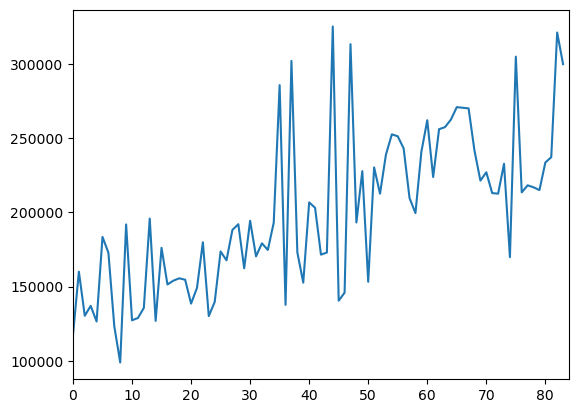

In [179]:
plt.xlim([0, len(final_images)])
plt.plot(x, y)